## Ein Recommender System für Filme
* Collaborativer Item-Item Filter
* Szenario:
    * <font color=green>Eingabe:</font> ein Film (den der User gerade gesehen hat)
    * <font color=blue>Ausgabe:</font> Liste von Filmen die als nächstes geschaut werden könnten
<BR>    
<font color=red>"User die diesen Film gesehen haben, sahen auch ..."</font>

### Daten: freie Datenbank mit Filmbewertungen: http://www.movielens.org/
* 943 User, 1682 Filme und 100000 Bewertungen
* Download als CSV Datei
<img src="IMG/movielens.png" width=75%>

### Movielens Datenstrukturen
* Relationale Datendank mit drei Tabellen [users, ratings, movies]
<img src="IMG/mtable.png" width=75%>

### Datenimport:

In [1]:
#read data to DataFrames
import pandas as pd
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('../../DATA/movielens100k/u.user', sep='|', names=u_cols, encoding = "ISO-8859-1")

r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('../../DATA/movielens100k/u.data', sep='\t', names=r_cols, encoding = "ISO-8859-1")

m_cols=['movie_id', 'title', 'release date', 'video release date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv('../../DATA/movielens100k/u.item', sep='|', names=m_cols ,encoding = "ISO-8859-1" )


### Dann schauen wir uns die Daten doch mal an ...

In [2]:
import numpy as np
print (np.shape(users), np.shape(ratings), np.shape(movies))
print (ratings[1:10])
print ("hello")

(943, 5) (100000, 4) (1682, 24)
   user_id  movie_id  rating  timestamp
1      186       302       3  891717742
2       22       377       1  878887116
3      244        51       2  880606923
4      166       346       1  886397596
5      298       474       4  884182806
6      115       265       2  881171488
7      253       465       5  891628467
8      305       451       3  886324817
9        6        86       3  883603013
hello


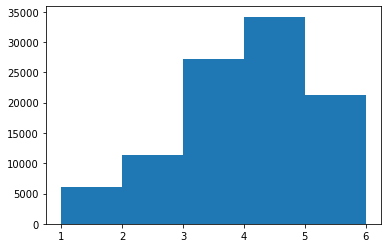

In [3]:
#schauen wir uns mal die die Verteilung der ratings an
import matplotlib.pyplot as plt
%matplotlib inline
res=plt.hist(ratings['rating'],[1,2,3,4,5,6])

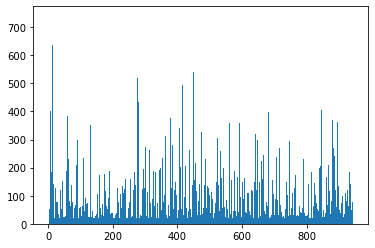

In [4]:
#wie viele Bewertungen geben user ab?
res=plt.hist(ratings['user_id'],943)

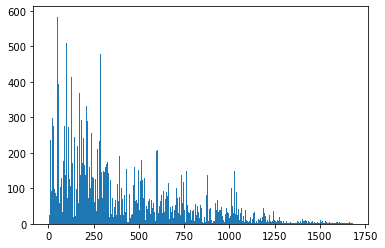

In [5]:
#wie oft werden Filme bewertet?
res=plt.hist(ratings['movie_id'],1682)

# Formalisierung: ein Item-Item Collaborative Filter

* User: $U := \{u_1, \dots, u_n\}, |U|=n$ <BR><BR>
* Filme (Produkte): $P := \{p_1, \dots, p_m\}, |P|=m$ <BR><BR>
* Kontext: Matrix $R$ der Größe $n\times m$<BR> mit Bewertungen $r_{ij},$ mit $ i\in 1\dots n, j\in 1\dots m$


In [6]:
#gerate matrix (this can be done more efficiently!)
R=np.zeros((np.shape(users)[0],np.shape(movies)[0]))
for i in range(np.shape(ratings)[0]):
    R[ratings['user_id'][i]-1, ratings['movie_id'][i]-1]=ratings['rating'][i]

### Plot $R$

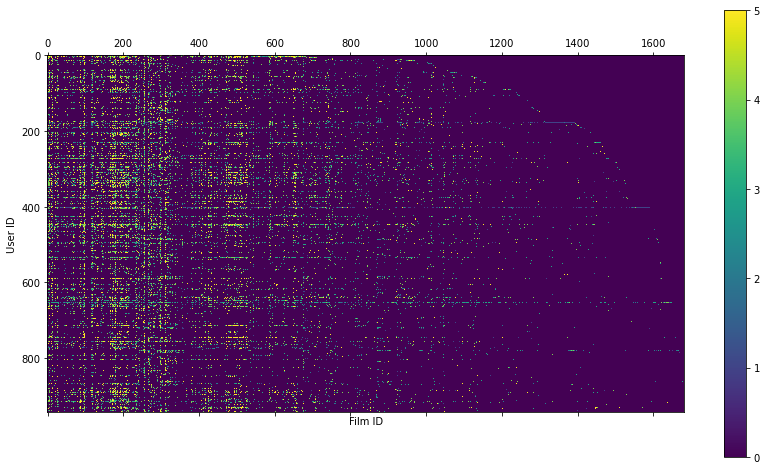

In [7]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)
#show matrix    
plt.matshow(R)
plt.xlabel('Film ID')
plt.ylabel('User ID')
plt.colorbar()


## Distanzmaße 
<br>
In $R$ sind alle 
* Bewertungen des $i$-ten Films im $i$-ten Spaltenvektor abgelegt
* Bewertungen des $j$-ten Users im $j$-ten Zeilenvektor abgelegt 
<BR><BR>

### Filmbewertungen := Spaltenvektoren in der Kontext Matrix $R$
<img src="IMG/R.png">


### Items: Kosinus-Distanz:
Für Filmbewertungen := Spaltenvektoren $\vec{a},\vec{b}$ in $R$ gilt die Distanz:<BR><BR>
$d_{cos}(\vec{a},\vec{b}) := { <\vec{a},\vec{b}> \over |\vec{a}||\vec{b}|}$ <BR><BR>
* mit den Skalarprodukt $ <\vec{a},\vec{b}>$<BR>
* und der Vektornorm $|\vec{a}|$<BR>
* mit dem Wertebereich  zwischen $0$ (keine Ähnlichkeit) und $1$ (Identisch)<BR>


In [8]:
 def CosineDist(a,b):
    res =  a.dot(b)
    norm = np.linalg.norm(a)*np.linalg.norm(b)
    if norm > 0: #norm ist null wenn keine Berwerung existiert -> Fallunterscheidung
        return res/norm
    else:
        return res

### Erstelle Kosinus-Distanz Matrix für alle Filme (offline)

In [9]:
#again, implementation not efficient: better use lamda opperators (later in this course)
D=np.zeros((np.shape(movies)[0],np.shape(movies)[0]))
for i in range(0,np.shape(movies)[0]):
    for j in range(0,np.shape(movies)[0]):
        if i!=j:
            D[i,j]=CosineDist(R[:,i],R[:,j])

In [9]:
np.save("movie_dist",D)

NameError: name 'D' is not defined

In [10]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.matshow(D)
plt.colorbar() 

NameError: name 'D' is not defined

### Anfragen an die Distanz-Matrix
* Suche die Top-5 ähnlichsten Filme 
* argmax auf Spalten / Zeilen von $D$
<img src="IMG/D.png" width="200">

In [28]:
def getTopN(movie_id,D, N=5):
    return D[movie_id,:].argsort()[-N:]


### Hilfsfunktionen

In [13]:
def getIDbyName(name):
    if np.size(movies.movie_id[movies.title.str.contains(name)]) > 0:
        m = int(movies.movie_id[movies.title.str.contains(name)][:1]), str(movies.title[movies.title.str.contains(name)][:1])
        return m[0]-1
    else:
        return -1
    
def getNameByID(IDs):
    res=movies.iloc[IDs]
    return res.title

## Implementierung Collaborative Item-Item Filter

In [14]:
def CII(title, D):
    if getIDbyName(title) > 0:
        print ("recommending movies for: '" + str(getNameByID(getIDbyName(title)))+"'")
        return getNameByID(getTopN(getIDbyName(title),D))[::-1]
    else:
        print ("no movie title containing " + str(title) + "found...")
        

In [30]:
CII("Casabl a",D)

recommending movies for: 'Casablanca (1942)'


133                                  Citizen Kane (1941)
131                             Wizard of Oz, The (1939)
483                           Maltese Falcon, The (1941)
473    Dr. Strangelove or: How I Learned to Stop Worr...
134                         2001: A Space Odyssey (1968)
Name: title, dtype: object

In [31]:
#wie oft kommt ein Film (per ID) in der DB for
id=180
print(movies.title[id])
np.sum(ratings.movie_id==id)

Return of the Jedi (1983)


221

## Quallitätsicherung - wie gut ist unser System objekitv?

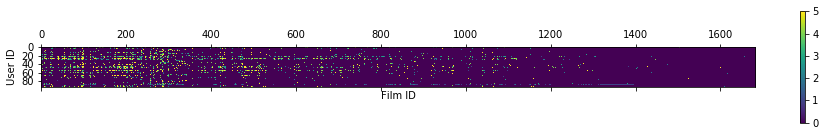

In [17]:
#split into train and test data
from sklearn.model_selection import train_test_split
R_train, R_test = train_test_split(R, test_size=0.1)
plt.matshow(R_test)
plt.xlabel('Film ID')
plt.ylabel('User ID')
plt.colorbar()

In [18]:
#again, implementation not efficient: better use lamda opperators (later in this course)
D_train=np.zeros((np.shape(movies)[0],np.shape(movies)[0]))
for i in range(0,np.shape(movies)[0]):
    for j in range(0,np.shape(movies)[0]):
        if i!=j:
            D_train[i,j]=CosineDist(R_train[:,i],R_train[:,j])

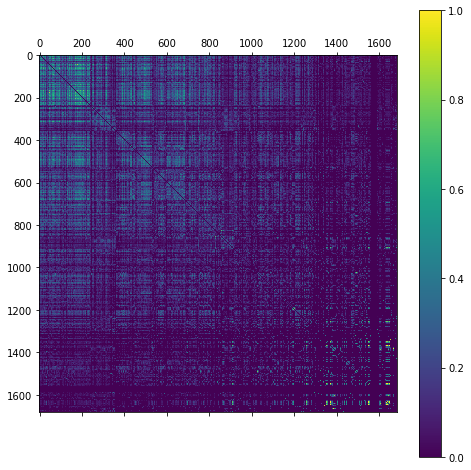

In [19]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.matshow(D_train)
plt.colorbar() 

In [32]:
#Anfrage auf dem Trainingsdatensatz
CII("Star",D_train)

recommending movies for: 'Star Wars (1977)'


180          Return of the Jedi (1983)
173     Raiders of the Lost Ark (1981)
171    Empire Strikes Back, The (1980)
0                     Toy Story (1995)
126              Godfather, The (1972)
Name: title, dtype: object

In [21]:
#get top 5 ids from random test user 23
np.argsort(R_test[23])[-5:]

array([106, 747, 750, 301,   0])

In [22]:
def Score_byID(ID, D, Test):
    #print ("Hit Scores for: ", getNameByID(ID))
    res_id = getTopN(ID,D)[::-1]
    res_title = getNameByID(getTopN(ID,D))[::-1]
    res_score = Test[res_id]
    return res_id, res_title, res_score, np.mean(res_score)
    

In [23]:
Score_byID(326,D_train, R_test[23])

(array([301, 287, 332, 331, 285]),
 301       L.A. Confidential (1997)
 287                  Scream (1996)
 332               Game, The (1997)
 331          Kiss the Girls (1997)
 285    English Patient, The (1996)
 Name: title, dtype: object,
 array([5., 2., 3., 0., 4.]),
 2.8)

In [24]:
#compute scores for all test users
def test_Score(D_train, R_test):
    userScores=[]
    for i in range(R_test.shape[0]):
        userScore=0
        userTop = np.argsort(R_test[i])[-5:]
        for e in userTop:
            res_id, res_title, res_score, av_score = Score_byID(e,D_train, R_test[i])
            userScore+=av_score
        userScores.append(userScore/(5))
    return userScores

In [25]:
test_res=test_Score(D_train,R_test)

(array([ 6.,  9., 11., 16., 17., 18., 10.,  4.,  3.,  1.]),
 array([0.2 , 0.64, 1.08, 1.52, 1.96, 2.4 , 2.84, 3.28, 3.72, 4.16, 4.6 ]),
 <a list of 10 Patch objects>)

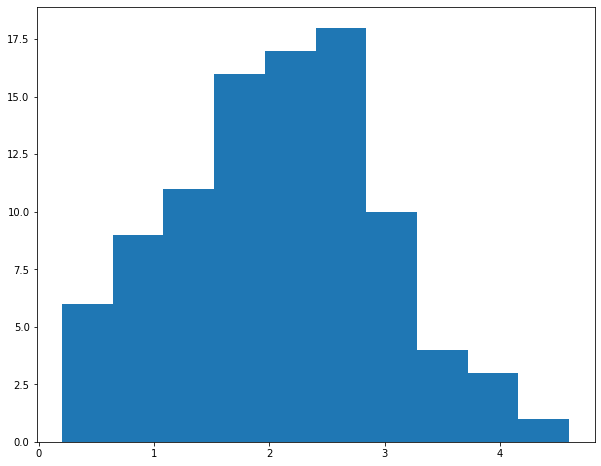

In [26]:
plt.hist(test_res)

In [27]:
np.mean(test_res)

2.064842105263158